In [1]:
import math
from pyqtorch.core.operation import Z, Y, X, RX
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.core.circuit import QuantumCircuit
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = [5, 5]

In [2]:
def target_function(x, function=None, factor=1, degree=1):
    """Defining a function that takes in x, function, factor, and degree.
    It then returns a result.  If function is None, it will return a
    trigonometric function. If function is not None, it will return a custom
    function.

    Args:
        x (_type_): _description_ function (_type_, optional): _description_.
        Defaults to None. factor (int, optional): _description_. Defaults to 1.
        degree (int, optional): _description_. Defaults to 3.

    Returns:
        _type_: _description_
    """
    result = 0
    if function == None:
        # some trigo function
        for i in range(degree):
            result += torch.cos(i * x) + torch.sin(i * x)
        result *= factor
    else:
        # custom function
        result = factor * function(x)

    return result

In [3]:
# Creating a dictionary with keys that are strings and values that are functions.
FUNCTIONS = {
    "0": None,
    "1": lambda a: 2 * a,
    "2": lambda a: a**2,
    "3": lambda a: a**3,
    "4": math.cos,
    "5": math.sin,
    "6": math.tan,
}
FUNCTION = "1"
function = FUNCTIONS[FUNCTION]
factor = 1.0  # 0.015
degree = 5

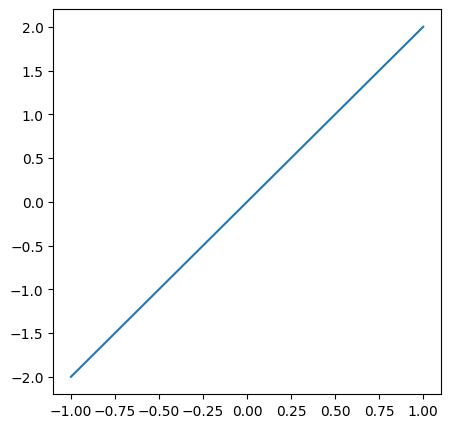

In [4]:
# Plotting the target function.
x = torch.tensor(np.linspace(-1, 1, 100))  # has to be -1, 1 interval for Cheb.
target_y = target_function(x, function=function, factor=factor, degree=degree)
plt.plot(x.numpy(), target_y.numpy())

# Using a graph feature map


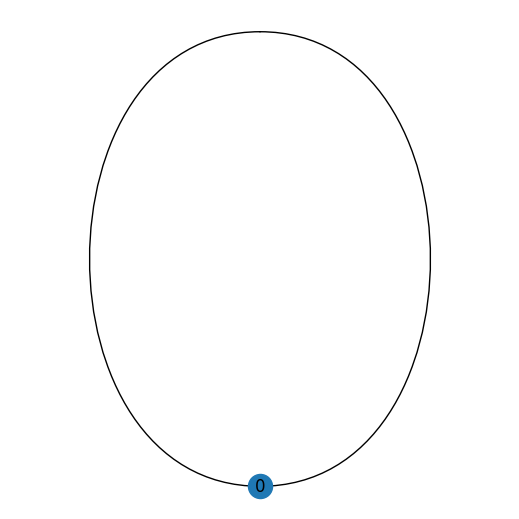

In [5]:
# from pyqtorch.matrices import generate_ising_from_graph, sum_N
from pyqtorch.matrices import ZZ, NN, single_N, single_Z
from pyqtorch.core.operation import batchedRY
from pyqtorch.core.circuit import QuantumCircuit


# random

# graph = nx.gnp_random_graph(n_nodes, 1., seed=42)

# or custom one

# graph = nx.Graph()
# graph.add_edge(0, 1, weight=0.5)
# graph.add_edge(1, 2, weight=0.1)
# graph.add_node(0, weight=100.)
# nx.draw(graph, with_labels=True)

# generate a graph from a linear system

# A = np.array([[2,2,2],[2,2,2],[2,2,2]])
# b = np.array([3,3,3])


def linear_system_to_graph(A, b):
    graph = nx.Graph()
    for idx, el in np.ndenumerate(b):
        graph.add_node(idx[0], weight=el)
    for idx, el in np.ndenumerate(A):
        if el != 0.0:
            graph.add_edge(idx[0], idx[1], weight=el)
            graph.add_edge(idx[0], idx[1], weight=el)
    return graph


# FIXME: Not correct behaviour, enumerate not working here.
# def linear_system_to_graph_torch(A, b):
#     graph = nx.Graph()
#     for idx, el in enumerate(b):
#         graph.add_node(idx, weight=el)
#     for idx, el in enumerate(A):
#         if el != 0.0:
#             graph.add_edge(idx[0], idx[1], weight=el)
#             graph.add_edge(idx[0], idx[1], weight=el)
#     return graph


A = np.array([[1]])
b = np.array([2])
graph = linear_system_to_graph(A, b)
nx.draw(graph, with_labels=True)


In [6]:
# graph = linear_system_to_graph_torch(A, b)

In [7]:
def generate_hamiltonian_from_graph(
    graph,
    precomputed_zz=None,
    type_ising="Z",
    device="cpu",
    use_edge_weights=True,
    use_self_loops=False,
    use_node_weights=False,
):
    """Given a nx graph, generate the corresponding Ising Hamiltonian in PyQ format."""

    # get the number of nodes
    N = graph.number_of_nodes()

    # construct the hamiltonian
    H = torch.zeros(2**N, dtype=torch.cdouble).to(device)

    # edge weights
    # go throught the edges and put the ZZ between correspoding nodes
    for edge in graph.edges.data():

        # check that the types are integers, otherwise code will run but graph will be incorrect
        assert type(edge[0]) == int
        assert type(edge[1]) == int

        # initialize edge weights
        edge_weight = torch.tensor(1, dtype=torch.cdouble)
        if use_edge_weights:
            if len(edge[2]) > 0:
                edge_weight = torch.tensor(
                    edge[2]["weight"], dtype=torch.cdouble
                )

        # if you already have ZZ(N, edge[0], edge[1], device) computed
        if precomputed_zz is not None:
            if (edge[0], edge[1]) in precomputed_zz[N]:
                key = (edge[0], edge[1])
            else:
                key = (edge[1], edge[0])
            H += edge_weight * precomputed_zz[N][key]
        else:
            # define
            if type_ising == "Z":
                if use_self_loops:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
            elif type_ising == "N":
                if use_self_loops:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
            else:
                raise ValueError("'type_ising' must be in ['Z', 'N']")

    # node weights
    if use_node_weights:
        for node in graph.nodes.data():
            assert type(node[0]) == int
            if len(node[1]) > 0:
                node_weight = torch.tensor(
                    node[1]["weight"], dtype=torch.cdouble
                )
                if type_ising == "N":
                    H += node_weight * single_N(N, node[0], device)
                elif type_ising == "Z":
                    H += node_weight * single_Z(N, node[0], device)
                else:
                    raise ValueError("'type_ising' must be in ['Z', 'N']")

    return H


n_nodes = graph.number_of_nodes()

graph_hamiltonian_raw = generate_hamiltonian_from_graph(
    graph,
    type_ising="Z",
    use_edge_weights=True,
    use_self_loops=True,
    use_node_weights=True,
)
graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])
graph_cost = graph_hamiltonian  # 1.2*ising_matrix - sum_N(n_nodes)
print(graph_cost)

tensor([[ 3.+0.j],
        [-1.+0.j]], dtype=torch.complex128)


In [8]:
# TODO: Here I need a batched version.
from pyqtorch.core.operation import U


class GraphHamiltonianEncoding(QuantumCircuit):
    def __init__(self, n_qubits, n_layers, graph_hamiltonian, parameters=None):
        super().__init__(n_qubits)
        self.gamma = nn.Parameter(
            torch.empty(
                n_layers,
            )
        )
        if parameters == None:
            self.reset_parameters()
        else:
            self.gamma = parameters

    def reset_parameters(self):
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)

    def forward(self, state, x):
        # make a graph for each x
        A = np.array([[1]])
        # print(x)
        # b = np.array([np.arccos(x.detach().numpy())])
        # FIXME: this does not work with batches, it runs but same gate is applied.
        b = np.array([x.detach().numpy()])
        graph = linear_system_to_graph(A, b)
        n_nodes = graph.number_of_nodes()
        graph_hamiltonian_raw = generate_hamiltonian_from_graph(
            graph,
            type_ising="Z",
            use_edge_weights=True,
            use_self_loops=True,
            use_node_weights=True,
        )
        # print(graph_hamiltonian_raw.shape)
        graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])
        # print(graph_hamiltonian)
        # print(graph_hamiltonian.shape)

        # print(state.shape)
        for g in self.gamma:
            state = state * torch.exp(-1j * g * graph_hamiltonian)
        return state


class SingleQubitRotation(QuantumCircuit):
    """
    Quantum circuit for the single qubit rotation.
    """

    def __init__(self, n_qubits, arbitrary=False):
        super().__init__(n_qubits)
        self.theta = nn.Parameter(torch.empty((self.n_qubits, 3)))
        self.reset_parameters()
        self.arbitrary = arbitrary

    def reset_parameters(self):
        init.uniform_(self.theta, -2 * np.pi, 2 * np.pi)

    def forward(self, state):
        for i, t in enumerate(self.theta):
            state = U(t[0], t[1], t[2], state, [i], self.n_qubits)
        return state

In [9]:
# TODO: This is to redesign to account for the batches.
class Model3(QuantumCircuit):
    """Model with feature map function."""

    def __init__(self, n_qubits, n_layers, graph_hamiltonian):
        super().__init__(n_qubits)
        # ansatzes
        self.ansatz1 = SingleQubitRotation(n_qubits, arbitrary=False)
        self.embedding = GraphHamiltonianEncoding(
            n_qubits,
            n_layers,
            graph_hamiltonian,
        )
        self.ansatz2 = SingleQubitRotation(n_qubits, arbitrary=False)

        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(
            torch.tensor(1e-5, dtype=torch.float64)
        )

    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)
        # new_state = self.param_coef * Y(state, [0], self.n_qubits)

        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state,
                      axis=0) + self.param_offset
        )


In [10]:
n_qubits = 1
n_layers = 1
model = Model3(n_qubits, n_layers, graph_hamiltonian)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10_000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 1.6252293192322922
Epoch 2 | Loss 1.6206846121572849
Epoch 3 | Loss 1.6161805669371894
Epoch 4 | Loss 1.611718672750579
Epoch 5 | Loss 1.607299099536129
Epoch 6 | Loss 1.6029234020529959
Epoch 7 | Loss 1.5985911550279497
Epoch 8 | Loss 1.5943036006245979
Epoch 9 | Loss 1.590061203204096
Epoch 10 | Loss 1.5858645629699852
Epoch 11 | Loss 1.5817146620202214
Epoch 12 | Loss 1.577611660614234
Epoch 13 | Loss 1.573556047342134
Epoch 14 | Loss 1.5695483332467137
Epoch 15 | Loss 1.5655885584514584
Epoch 16 | Loss 1.5616777089388694
Epoch 17 | Loss 1.557815449937217
Epoch 18 | Loss 1.5540030089960026
Epoch 19 | Loss 1.550240033750086
Epoch 20 | Loss 1.5465266673690596
Epoch 21 | Loss 1.5428630405108954
Epoch 22 | Loss 1.5392499155396597
Epoch 23 | Loss 1.5356865063948104
Epoch 24 | Loss 1.5321731927500375
Epoch 25 | Loss 1.528710441054715
Epoch 26 | Loss 1.525298020176863
Epoch 27 | Loss 1.5219358761533264
Epoch 28 | Loss 1.5186237841598527
Epoch 29 | Loss 1.5153617524583813
Epo

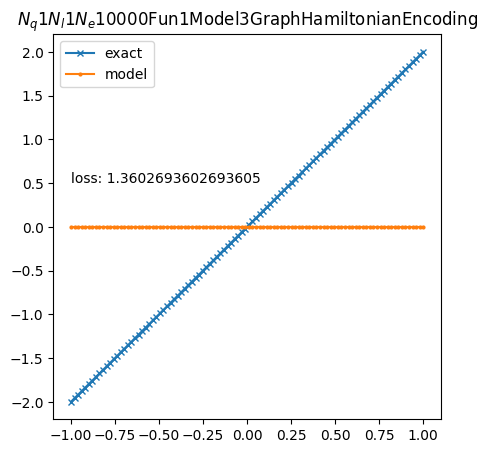

In [11]:
with torch.no_grad():
    y = model(x)

# Plotting the exact function and the model function.
plt.plot(x.numpy(), target_y.numpy(), label="exact", marker="x", markersize=4)
plt.plot(x.numpy(), y.numpy(), label="model", marker="o", markersize=2)
plt.legend()
plt.title(
    f"$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss.detach().numpy()}")
# plot text in the plot
plt.show()

---

# Below I try to understand how the dimensions of tensors work here.

I check how the state and Hamiltonian are represented.


In [12]:
# Generate state with different batches.
batch_size = 3
n_qubits = 1
state = QuantumCircuit(n_qubits).init_state(batch_size)
state = state.reshape((2**n_qubits, batch_size))
print(state)
print(state.shape)
# Reshaping was only necessary for the expectation value.

tensor([[1.+0.j, 1.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]], dtype=torch.complex128)
torch.Size([2, 3])


In [13]:
# Generate batched Hamiltonian matrix.
# There is a x for each graph so graph should change.
# So far they are the same applied to all states.
A = np.array([[1]])
# print(x)
# b = np.array([np.arccos(x.detach().numpy())])
b = np.array([x.detach().numpy()])
graph = linear_system_to_graph(A, b)
n_nodes = graph.number_of_nodes()
graph_hamiltonian_raw = generate_hamiltonian_from_graph(
    graph,
    type_ising="Z",
    use_edge_weights=True,
    use_self_loops=True,
    use_node_weights=True,
)

print("before:", state)
print(graph_hamiltonian_raw)
print(graph_hamiltonian_raw.shape)
graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])
print(graph_hamiltonian)
print(graph_hamiltonian.shape)

state = state * torch.exp(-1j * graph_hamiltonian)
print("after:", state)
print(state.shape)
# The same tensor is applied to the all states.


before: tensor([[1.+0.j, 1.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]], dtype=torch.complex128)
tensor([2.+0.j, 0.+0.j], dtype=torch.complex128)
torch.Size([2])
tensor([[2.+0.j],
        [0.+0.j]], dtype=torch.complex128)
torch.Size([2, 1])
after: tensor([[-0.4161-0.9093j, -0.4161-0.9093j, -0.4161-0.9093j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j]],
       dtype=torch.complex128)
torch.Size([2, 3])


In [14]:
n_nodes = 2
batch_size = 3
hamiltonians = torch.rand(([2] * n_nodes + [batch_size]), dtype=torch.float64)
print(hamiltonians.shape)
print(hamiltonians)
hamiltonians[:, 0]


torch.Size([2, 2, 3])
tensor([[[0.5575, 0.2297, 0.2463],
         [0.1958, 0.7289, 0.0118]],

        [[0.1559, 0.0522, 0.2602],
         [0.2496, 0.9482, 0.1076]]], dtype=torch.float64)


tensor([[0.5575, 0.2297, 0.2463],
        [0.1559, 0.0522, 0.2602]], dtype=torch.float64)

In [15]:
# Try creating and joining the graph tensors.
first_tensor = torch.rand(([2] * n_nodes + [1]), dtype=torch.float64)
second_tensor = torch.rand(([2] * n_nodes + [1]), dtype=torch.float64)
third_tensor = torch.cat((first_tensor, second_tensor), -1)
print(third_tensor.shape)
print(third_tensor)
# You can join tensors that you created to work for the batch.

torch.Size([2, 2, 2])
tensor([[[0.6775, 0.6644],
         [0.9700, 0.1541]],

        [[0.8707, 0.4024],
         [0.8476, 0.7439]]], dtype=torch.float64)


In [16]:
# Generate state with different batches.
batch_size = 2
n_qubits = 2
state = QuantumCircuit(n_qubits).init_state(batch_size)
print(state.shape)
# state = state.reshape((2**n_qubits, batch_size))
print(state)
# print(state.shape)
print(torch.exp(-1j * third_tensor))
theta = nn.Parameter(torch.tensor(1, dtype=torch.complex128))
third_tensor = theta * third_tensor
state = state * torch.exp(-1j * third_tensor)
# state = state.reshape((2**n_qubits, batch_size))
print(state)
print(state.shape)
# Reshaping can be done at the end.

torch.Size([2, 2, 2])
tensor([[[1.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]]], dtype=torch.complex128)
tensor([[[0.7791-0.6269j, 0.7873-0.6166j],
         [0.5653-0.8249j, 0.9882-0.1535j]],

        [[0.6443-0.7648j, 0.9201-0.3917j],
         [0.6618-0.7497j, 0.7358-0.6772j]]], dtype=torch.complex128)
tensor([[[0.7791-0.6269j, 0.7873-0.6166j],
         [0.0000+0.0000j, 0.0000+0.0000j]],

        [[0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j]]], dtype=torch.complex128,
       grad_fn=<MulBackward0>)
torch.Size([2, 2, 2])


In [17]:
# You can simply create the graph hamiltonians.

from functools import reduce

list_tensors = [first_tensor, second_tensor, first_tensor, first_tensor]
third_tensor = reduce(lambda x, y: torch.cat((x, y), -1), list_tensors)
print(third_tensor.shape)
third_tensor
# You see that it can do concatenation.


torch.Size([2, 2, 4])


tensor([[[0.6775, 0.6644, 0.6775, 0.6775],
         [0.9700, 0.1541, 0.9700, 0.9700]],

        [[0.8707, 0.4024, 0.8707, 0.8707],
         [0.8476, 0.7439, 0.8476, 0.8476]]], dtype=torch.float64)

---

### The steps are:

#### 1. Create the Hamiltonian tensors that are created once for all data.

#### 2. Reduce to the batched version.

#### 3. Apply one the state via an exponential.

#### 4. See the results of the training.


In [18]:
#### 1. Create the Hamiltonian tensors that are created once for all data.

# Generate batched Hamiltonian matrix.
# There is a x for each graph so graph should change.
# So far they are the same applied to all states.

# All data input is stored in x.
print("Generating inputs for all graphs...")
print(x)

print("Generating batched Hamiltonian matrix...")


def create_graph_hamiltonians(x_el):
    # x is a single value
    A = np.array([[1]])
    b = np.array([x_el.detach().numpy()])
    graph = linear_system_to_graph(A, b)
    n_nodes = graph.number_of_nodes()
    graph_hamiltonian_raw = generate_hamiltonian_from_graph(
        graph,
        type_ising="Z",
        use_edge_weights=True,
        use_self_loops=True,
        use_node_weights=True,
    )
    return graph_hamiltonian_raw.reshape([2] * n_nodes + [1])


# All Hamiltonian tensors.

list_hamiltonians = [create_graph_hamiltonians(x_el) for x_el in x]
print(list_hamiltonians)

# Reduce to 1 tensor.

from functools import reduce

batched_hamiltonians = reduce(
    lambda x, y: torch.cat((x, y), -1), list_hamiltonians
)
batched_hamiltonians
print(batched_hamiltonians.shape)


def create_batched_graph_hamiltonians(x):
    list_hamiltonians = [create_graph_hamiltonians(x_el) for x_el in x]
    batched_hamiltonians = reduce(
        lambda x, y: torch.cat((x, y), -1), list_hamiltonians
    )
    return batched_hamiltonians


batched_hamiltonians = create_batched_graph_hamiltonians(x)

Generating inputs for all graphs...
tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
        -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
        -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
        -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
        -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
        -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
        -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
         0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
         0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
         0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
         0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
         0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
    

In [19]:
# Test multiplying that Hamiltonian with tensor.

# Generate state with different batches.
batch_size = len(x)
n_qubits = 1
state = QuantumCircuit(n_qubits).init_state(batch_size)
print(state.shape)
# state = state.reshape((2**n_qubits, batch_size))
print(state)
# print(state.shape)
theta = nn.Parameter(torch.tensor(1, dtype=torch.complex128))
batched_hamiltonians = theta * batched_hamiltonians
state = state * torch.exp(-1j * batched_hamiltonians)
# state = state.reshape((2**n_qubits, batch_size))
print(state)
print(state.shape)
# Reshaping can be done at the end for different expectation values.


torch.Size([2, 100])
tensor([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
         1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 

### It does work! we generated the batched Hamiltonians and mutiplied

### on the copies of the same state.

---


In [37]:
# TODO: This is to redesign to account for the batches.


from pyqtorch.core.operation import U


class GraphHamiltonianEncodingBatched(QuantumCircuit):
    def __init__(self, n_qubits, n_layers, graph_hamiltonians, parameters=None):
        super().__init__(n_qubits)
        self.gamma = nn.Parameter(
            torch.empty(
                n_layers,
            )
        )
        if parameters == None:
            self.reset_parameters()
        else:
            self.gamma = parameters
        self.graph_hamiltonians = graph_hamiltonians

    def reset_parameters(self):
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)

    def forward(self, state):
        for g in self.gamma:
            state = state * torch.exp(-1j * g * self.graph_hamiltonians)
        return state, self.gamma


class Model4(QuantumCircuit):
    """Model with feature map function."""

    def __init__(self, n_qubits, n_layers, graph_hamiltonians):
        super().__init__(n_qubits)
        # ansatzes
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.ansatz1 = SingleQubitRotation(n_qubits, arbitrary=False)
        self.embedding = GraphHamiltonianEncodingBatched(
            n_qubits, n_layers, graph_hamiltonians
        )
        self.ansatz2 = SingleQubitRotation(n_qubits, arbitrary=False)

        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(
            torch.tensor(1e-5, dtype=torch.float64)
        )
        self.gamma = None
        # graphs

    def forward(self):
        """Fixed size x for the training."""
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state, gamma = self.embedding(state)
        state = self.ansatz2(state)
        self.gamma = gamma
        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)
        # new_state = self.param_coef * Y(state, [0], self.n_qubits)

        # compute the overlap
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        # print("gamma for train:", self.gamma)

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )

    def eval_model(self, x):
        """Evaluate the model using any x, of any size."""
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)

        # feature map
        batched_hamiltonians = create_batched_graph_hamiltonians(x)
        # print("gamma for eval:", self.gamma)
        embedding = GraphHamiltonianEncodingBatched(
            self.n_qubits,
            self.n_layers,
            batched_hamiltonians,
            parameters=self.gamma,
        )
        state, _ = embedding(state)

        state = self.ansatz2(state)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)
        # new_state = self.param_coef * Y(state, [0], self.n_qubits)

        # compute the overlap
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )


n_qubits = 1
n_layers = 1

batched_hamiltonians = create_batched_graph_hamiltonians(x)
model = Model4(n_qubits, n_layers, batched_hamiltonians)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10_000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model()
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 1.5387342797929517
Epoch 2 | Loss 1.5340533202627304
Epoch 3 | Loss 1.52938820037773
Epoch 4 | Loss 1.5247393392214748
Epoch 5 | Loss 1.5201080054213185
Epoch 6 | Loss 1.5154931123001287
Epoch 7 | Loss 1.5108955350419904
Epoch 8 | Loss 1.5063160088217102
Epoch 9 | Loss 1.5017545761570343
Epoch 10 | Loss 1.4972115109362676
Epoch 11 | Loss 1.4926864735409902
Epoch 12 | Loss 1.4881805090325586
Epoch 13 | Loss 1.4836935340760058
Epoch 14 | Loss 1.4792257531718809
Epoch 15 | Loss 1.474777579874842
Epoch 16 | Loss 1.4703492652784516
Epoch 17 | Loss 1.4659408859881835
Epoch 18 | Loss 1.461551907171185
Epoch 19 | Loss 1.4571834613789734
Epoch 20 | Loss 1.4528352354846428
Epoch 21 | Loss 1.4485073090923941
Epoch 22 | Loss 1.4442003748517949
Epoch 23 | Loss 1.4399139052084238
Epoch 24 | Loss 1.435647867918365
Epoch 25 | Loss 1.431403098983044
Epoch 26 | Loss 1.427179166178023
Epoch 27 | Loss 1.4229767846823211
Epoch 28 | Loss 1.418794849203876
Epoch 29 | Loss 1.4146343551192053
Ep

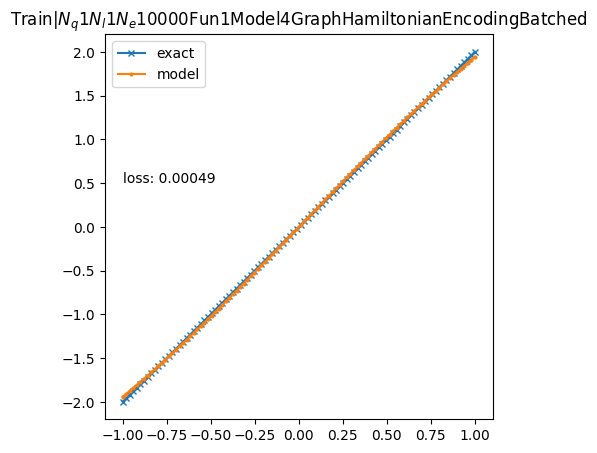

In [40]:
with torch.no_grad():
    y = model()

# Plotting the exact function and the model function.
plt.plot(x.numpy(), target_y.numpy(), label="exact", marker="x", markersize=4)
plt.plot(x.numpy(), y.numpy(), label="model", marker="o", markersize=2)
plt.legend()
plt.title(
    f"Train|$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss.detach().numpy():.5f}")
# plot text in the plot
plt.show()

In [23]:
# Print parameters.
for ps in model.parameters():
    print(ps)

Parameter containing:
tensor(0.6838, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(-0.2500, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-4.5834], requires_grad=True)
Parameter containing:
tensor([[ 4.0384, -0.8752, -1.6177]], requires_grad=True)
Parameter containing:
tensor([[-3.0947,  0.9638,  2.4792]], requires_grad=True)


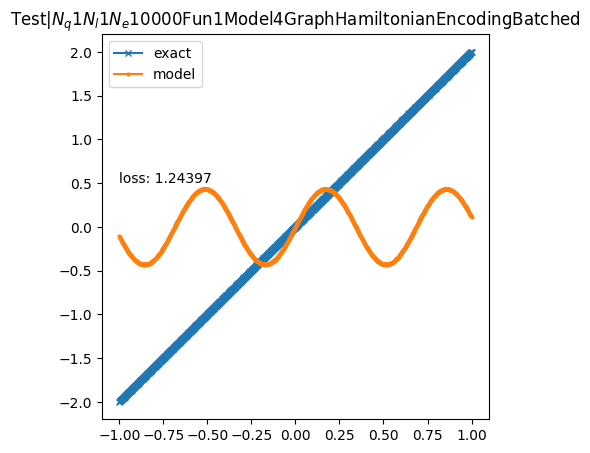

In [24]:
# Plotting the target function.
x_test = torch.tensor(
    np.linspace(-1, 1, 1000)
)  # has to be -1, 1 interval for Cheb.
target_y_test = target_function(
    x_test, function=function, factor=factor, degree=degree
)


with torch.no_grad():
    y_test = model.eval_model(x_test)

# Compute loss for the target.
loss_test = F.mse_loss(target_y_test, y_test)

# Plotting the exact function and the model function.
plt.plot(
    x_test.numpy(),
    target_y_test.numpy(),
    label="exact",
    marker="x",
    markersize=4,
)
plt.plot(
    x_test.numpy(), y_test.numpy(), label="model", marker="o", markersize=2
)
plt.legend()
plt.title(
    f"Test|$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss_test.detach().numpy():.5f}")
# plot text in the plot
plt.show()

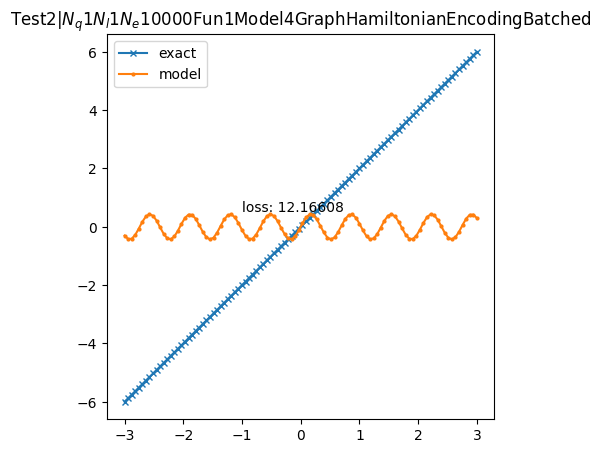

In [25]:
# Plotting the target function.
x_test = torch.tensor(
    np.linspace(-3, 3, 100)
)  # has to be -1, 1 interval for Cheb.
target_y_test = target_function(
    x_test, function=function, factor=factor, degree=degree
)


with torch.no_grad():
    y_test = model.eval_model(x_test)

# Compute loss for the target.
loss_test = F.mse_loss(target_y_test, y_test)

# Plotting the exact function and the model function.
plt.plot(
    x_test.numpy(),
    target_y_test.numpy(),
    label="exact",
    marker="x",
    markersize=4,
)
plt.plot(
    x_test.numpy(), y_test.numpy(), label="model", marker="o", markersize=2
)
plt.legend()
plt.title(
    f"Test2|$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss_test.detach().numpy():.5f}")
# plot text in the plot
plt.show()

***
# Outcome

- Graph-based feature map (GBFM) without batching was not working as expected.
- Graph-based feature map had batching implemented.
- We can fit a linear function on the wanted domain using GBFM.
- It is basically a summary of how to proceed with full implementation in the linear solver code.
